The following work is generating the volatility surface for Binary options.

The surface is generated using the SVI model and calibrated with market data.

The model can be optimized in terms of speed of calculations.


In [ ]:
import requests
import json
import pandas as pd
from datetime import datetime as dt
import numpy as np
import scipy.optimize as opt
from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import seaborn as sns 
import plotly.graph_objects as go
import plotly.express as px
from scipy.optimize import curve_fit
from scipy.interpolate import PchipInterpolator
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from numpy import interp
from math import log, sqrt, pi, exp
from scipy.stats import norm
import itertools
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def d1(S,K,T,r,sigma):
  return(np.log(S/K)+(r+sigma**2/2)*(T/365))/(np.multiply(sigma,np.sqrt(T/365)))
def d2(S,K,T,r,sigma):
  return d1(S,K,T,r,sigma)-sigma*np.sqrt(T/365)

In [ ]:
#Due to property rights , the link cannot be displayed in the code. 
def get_data(currency, maturity, premium, start, end):  
  response = requests.get('Link goes here'+currency + '/'+ maturity+'/'+premium+'?start='+start+'&end=' +end).json()
  data = pd.DataFrame(response)
  data['date']=pd.to_datetime(data['date'].astype(int),unit='ms')
  return data

In [ ]:
def add_days_to_go(data): 
  list_days_to_go = []
  for i in range(data.shape[0]):
    if data['maturity'][i] =='1w':
      list_days_to_go.append(7)
    if data['maturity'][i] =='2w':
      list_days_to_go.append(14)
    if data['maturity'][i] =='1m':
      list_days_to_go.append(30)
    if data['maturity'][i] =='3m':
      list_days_to_go.append(90)
    if data['maturity'][i] =='6m':
      list_days_to_go.append(180)
  data['DaysToGo'] = list_days_to_go
  return data


In [ ]:
def IV_bisection(S,K,T,r,premium,tol):
  sigma_1 = 0.1
  sigma_2 = 2
  while (sigma_2-sigma_1> tol):
      if norm.cdf(d2(S,K,T,0,(sigma_1+sigma_2)*0.5)) - premium > 0:
          sigma_2 = ((sigma_1+sigma_2))/2
      else :
          sigma_1 = ((sigma_1+sigma_2))/2

  return sigma_1

In [ ]:
def delta_dig(S,K,T,r, sigma):
  nominator = norm.pdf(d2(S,K,T,r, sigma))
  denominator = S * sigma * np.sqrt(T/365)
  delta = nominator / denominator
  return delta * 100

In [ ]:
def gamma_dig(S,K,T,r, sigma): 
  nominator =  - norm.pdf(d2(S,K,T,r, sigma)) * d1(S,K,T,r, sigma)
  denominator = S**2  * sigma**2 * (T/365)
  gamma = nominator / denominator
  return gamma *100


In [ ]:
def vega_dig (S,K,T,r, sigma):
  nominator = - d1(S,K,T,r, sigma) * norm.pdf(d2(S,K,T,r, sigma))
  denominator = sigma
  # print(nominator / denominator)
  return nominator / denominator

In [ ]:
def add_iv(data):
  list_iv = []
  for i in range(data.shape[0]): 
    S = data.spot[i]
    K = data.strike[i]
    T = data.DaysToGo[i]
    premium = data.premium[i]
    r = 0
    list_iv.append(IV_bisection(S,K,T,r,premium/100,0.0000001))
  data['IV'] = list_iv
  return data

In [ ]:
def add_deltas(data):
  list_deltas = []
  for i in range(data.shape[0]): 
    S = data.spot[i]
    K = data.strike[i]
    T = data.DaysToGo[i]
    # premium = btc_calls.premium[i]
    sigma = data.IV[i]
    r = 0
    list_deltas.append(delta_dig(S,K,T,r, sigma))
  data['delta'] = list_deltas
  return data


In [ ]:
def add_gammas(data):
  list_gammas = []
  for i in range(data.shape[0]): 
    S = data.spot[i]
    K = data.strike[i]
    T = data.DaysToGo[i]
    # premium = btc_calls.premium[i]
    sigma = data.IV[i]
    r = 0
    list_gammas.append(gamma_dig(S,K,T,r, sigma))
  data['gamma'] = list_gammas
  return data

In [ ]:
def add_vegas(data):
  list_vegas = []
  for i in range(data.shape[0]): 
    S = data.spot[i]
    K = data.strike[i]
    T = data.DaysToGo[i]
    # premium = btc_calls.premium[i]
    sigma = data.IV[i]
    r = 0
    list_vegas.append(vega_dig(S,K,T,r, sigma))
  data['vega'] = list_vegas
  return data

In [ ]:
def data_preprocessing(dataframe): 
  df = dataframe.copy()
  df.rename({'c' : 'strike' , 's' : 'spot'},axis = 1 , inplace=True)
  df.drop('p',axis = 1,inplace=True) 
  df['Moneyness'] = np.log(df['strike']/df['spot'])
  df['premium'] = pd.to_numeric(df['premium'])
  df = add_days_to_go(df)
  df.reset_index(inplace=True, drop=True)
  df = add_iv(df)
  df = add_deltas(df)
  df = add_gammas(df)
  df = add_vegas(df)
  df.fillna(0,inplace=True)
  
  return df

## Implied Volatility surface construction: 

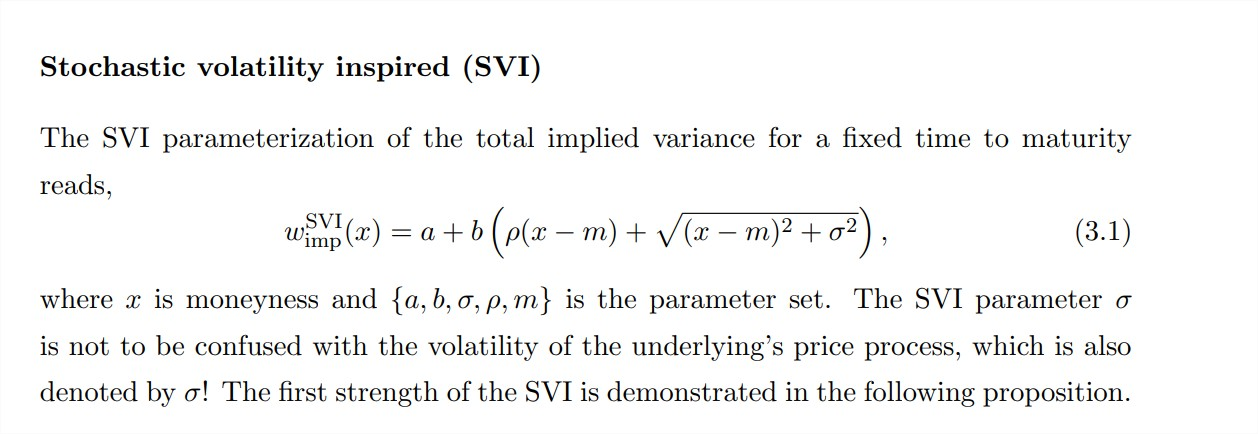

Source :  http://kth.diva-portal.org/smash/get/diva2:744907/FULLTEXT02.pdf

In [ ]:
def SVI(x,a,b,rho,m,s): 
  # x : moneyness 
  # result : iv
  return np.sqrt((a+b*(rho*(x-m)+np.sqrt((x-m)**2+s**2))))

In [ ]:
def Calibration(S,K,T,premium,x,weights,init_var,method_name,maxiter=20,epsilon=10**(-20)):
    opt_rmse = 1 

    def svi_loss(parameters): 
      a,b,rho,m,s = parameters
      return np.sqrt(np.mean((norm.cdf(d2(S,K,T,0,SVI(x,a,b,rho,m,s))) - premium)**2))

    for i in range(1,maxiter + 1): 
      #bounds = ((2*min(x.min(),0), 2*max(x.max(),0)),(1e-6,1))
      a_opt, b_opt, rho_opt, m_opt,s_opt = opt.minimize(svi_loss,init_var,method = method_name, tol = 10**(-8)).x

      # a_opt,d_opt,c_opt = calculate_adc(iv,x,m_opt,s_opt)
      parameters = (a_opt, b_opt, rho_opt, m_opt,s_opt)
      opt_rmse1 = svi_loss(parameters)
      if i>1 and (abs(opt_rmse - opt_rmse1)<epsilon): 
        break
      opt_rmse = opt_rmse1 
      init_var = [a_opt, b_opt, rho_opt,m_opt,s_opt]
    result = np.array([a_opt, b_opt, rho_opt,m_opt,s_opt])

    opt_parameters = result


    return opt_parameters

In [ ]:
list_maturities = ['1w','2w','1m','3m','6m']
list_premiums = ['5','10','15','20']
data = pd.DataFrame()
for mat in list_maturities: 
  for pre in list_premiums:
    data_test = get_data('btc',mat,pre,'2022-11-22','2022-11-24')
    data_test['maturity'] = [mat for i in range(data_test.shape[0])]
    data_test['premium'] = [pre for i in range(data_test.shape[0])]
    data = pd.concat([data,data_test])
    data.reset_index(inplace=True, drop=True)
    data['premium'] = pd.to_numeric(data['premium'])
    

In [ ]:
method_name = "Nelder-Mead"
new_df = pd.DataFrame()
for ttm in sorted(data_proc.DaysToGo.unique()): 
  if ttm <90: 
    continue
  else: 
    data_proc_2 = data_proc[data_proc['DaysToGo'] == ttm]
    data_proc_2.sort_values('Moneyness',inplace=True)
    data_proc_2.reset_index(inplace=True, drop=True)
    moneyness = data_proc_2[data_proc_2.DaysToGo ==ttm].Moneyness 
    ivs = data_proc_2[data_proc_2.DaysToGo ==ttm].IV 
    premium = data_proc_2[data_proc_2.DaysToGo ==ttm].premium/100
    T =  data_proc_2[data_proc_2.DaysToGo ==ttm].DaysToGo
    weights = data_proc_2[data_proc_2.DaysToGo == ttm].vega.values
    S = data_proc_2[data_proc_2.DaysToGo == ttm].spot
    K = data_proc_2[data_proc_2.DaysToGo == ttm].strike
    a,b,rho,m,s = Calibration(S,K,ttm,premium,moneyness,weights,[0.1,0.3,-0.05,0.05,0.2],"Nelder-Mead",10)
    m_vec = np.linspace(2*min(moneyness),2*max(moneyness),50)
    premium_vec = norm.cdf(d2(S,K,ttm,0,SVI(moneyness,a,b,rho,m,s)))
    new_df['premium_model'] = premium_vec
    new_df['premium_market'] = premium
    break



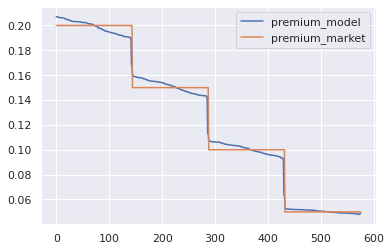

In [ ]:
new_df.plot()

In [ ]:
# gives parameters of SVI for a given slice
def params_new(ttm):
    data_proc_2 = data_proc[data_proc['DaysToGo'] == ttm]
    # data_proc_2 = data_proc[data_proc.premium == pre]
    data_proc_2.sort_values('Moneyness',inplace=True)
    data_proc_2.reset_index(inplace=True, drop=True)
    moneyness = data_proc_2[data_proc_2.DaysToGo ==ttm].Moneyness 
    ivs = data_proc_2[data_proc_2.DaysToGo ==ttm].IV 
    premium = data_proc_2[data_proc_2.DaysToGo ==ttm].premium/100
    T =  data_proc_2[data_proc_2.DaysToGo ==ttm].DaysToGo
    weights = data_proc_2[data_proc_2.DaysToGo == ttm].vega.values
    S = data_proc_2[data_proc_2.DaysToGo == ttm].spot
    K = data_proc_2[data_proc_2.DaysToGo == ttm].strike
    if ttm < 7: 
      pass
    else: 
      a,b,rho,m,s = Calibration(S,K,ttm,premium,moneyness,weights,[0.1,0.3,-0.05,0.05,0.2],"Nelder-Mead",10)
    return [a,b,rho,m,s]

In [ ]:
def params_skew(data_proc,number_parameters = 5):
  # This function fits each skew using a map function and need to be stored
  # data_proc: processed data 
  # number_parameters : number of parameters of fitting model ( 5 for SVI ) 
  # Result : Matrix (number of maturities in the market, number of model parameters + 1)
  # First column in the matrix is maturities in the market, the rest are vector of parameters across these maturities

  sorted_ttm_vec = data_proc.DaysToGo.sort_values().unique()
  params_matrix = np.zeros((len(sorted_ttm_vec),number_parameters+1))
  params_matrix[:,0] = sorted_ttm_vec
  params_list = []
  for i in range(len(sorted_ttm_vec)): 
    ttm = sorted_ttm_vec[i]
    params_list.append(params_new(ttm))
  params_matrix[:,1:] = np.array(params_list)
  return params_matrix

In [ ]:
params_matrix = params_skew(data_proc,number_parameters = 5)

In [ ]:
def implied_vol(m,t,params_matrix):
  # moneyness : strike price given by the user: ln(K/S)
  # t : Time to expiry given by the user in days
  # params_matrix : matrix of optimal parameters across market maturities 
  ttm_vec = params_matrix[:,0]
  y = SVI(m,params_matrix[:,1],params_matrix[:,2],params_matrix[:,3],params_matrix[:,4],params_matrix[:,5]) # vector of implied vol needed for interpolation 
  x = params_matrix[:,0]
  ys = x*y # total variance
  x = np.insert(x,0,0) 
  ys = np.insert(ys,0,0)
  cs = interp1d(x,ys,fill_value = "extrapolate")
  lin = cs(t)
  final_iv = np.array(lin/t)
  return final_iv

In [ ]:
implied_vol(np.log(22231.47/16605.82), 180, params_matrix)

array(0.71506875)

In [ ]:
params_matrix = params_skew(data_proc,number_parameters = 5)

In [ ]:
m = np.linspace(2 * 0.061619, 2 * 0.70522 ,100)
T = np.linspace(1,180,100)
xx,yy = np.meshgrid(m,T)
Z = np.array([implied_vol(m,t,params_matrix) for KT,TT in zip(xx,yy) for m,t in zip(KT,TT)]).reshape(xx.shape[0],xx.shape[1])

In [ ]:
fig = go.Figure(data = [go.Surface(z=Z,x=m,y=T)])
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))
fig.update_layout(title='Implied Volatility Surface', autosize=False,
                  scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),scene = dict(
                    xaxis_title='Moneyness',
                    yaxis_title='Time to expiration (days)',
                    zaxis_title='Implied Vol'),
                  width=680, height=680,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.write_html("strike_surface.html")
fig.show()

In [ ]:
# Calculates a call option price using implied volatility from the implied vol surface
def call_value(k,s,t,r): 
  m = np.log(k/s)
  vol = implied_vol(m,t,params_matrix)
  p0 = norm.cdf(d2(s,k,t,r,implied_vol(m,t,params_matrix))) 
  return p0

## Final Results : A Dataframe displaying each option caracteristics and the premium we got from the model

In [ ]:
list_maturities = ['1w','2w','1m','3m','6m']
list_premiums = ['5','10','15','20']
list_mat = []
list_pre = []
list_model_pre = []
list_spots = []
list_strikes = []
final_df = pd.DataFrame()
for mat in list_maturities:
  for pre in list_premiums:
    data_2 =  get_data('btc',mat,pre,'2022-11-25', '2022-11-25')
    s = data_2.s[0]
    k = data_2.c[0]
    list_mat.append(mat)
    list_pre.append(pre)
    if mat =='1w':
      matu = 7
    if mat =='2w':
      matu = 14
    if mat =='1m':
      matu = 30
    if mat =='3m':
      matu = 90
    if mat =='6m':
      matu = 180
    model_pre = call_value(k,s,matu,0)
    list_model_pre.append(model_pre)
    list_spots.append(s)
    list_strikes.append(k)

final_df['spot'] = list_spots
final_df['strike'] = list_strikes
final_df['maturity'] = list_mat
final_df['market_premium'] = list_pre
final_df['model_premium'] = list_model_pre
final_df['moneyness'] = np.log(final_df['strike']/final_df['spot'])
final_df['market_premium'] = pd.to_numeric(final_df['market_premium'])
final_df['model_premium'] = 100 * final_df['model_premium']
final_df['error'] = final_df['model_premium'] - final_df['market_premium']
final_df = add_days_to_go(final_df)
final_df


spot    strike maturity  market_premium  model_premium  moneyness  \
0   16605.82  19049.08       1w               5       6.673700   0.137266   
1   16605.82  18335.04       1w              10      12.709447   0.099061   
2   16605.82  17944.83       1w              15      17.777795   0.077549   
3   16605.82  17671.37       1w              20      22.283842   0.062193   
4   16605.82  20064.77       2w               5       6.071059   0.189212   
5   16605.82  19036.16       2w              10      12.298106   0.136587   
6   16605.82  18479.98       2w              15      17.538729   0.106935   
7   16605.82  18115.61       2w              20      21.857465   0.087021   
8   16605.82  22076.40       1m               5       5.027708   0.284756   
9   16605.82  20427.62       1m              10      11.482271   0.207135   
10  16605.82  19590.95       1m              15      16.595929   0.165314   
11  16605.82  18988.78       1m              20      21.167284   0.134095   
12  16605.82  27083.28       3m               5       5.197923   0.489163   
13  16605.82  23550.08       3m              10      10.655603   0.349376   
14  16605.82  21902.07       3m              15      15.830601   0.276828   
15  16605.82  20719.01       3m              20      20.648778   0.221298   
16  16605.82  32471.25       6m               5       5.206042   0.670602   
17  16605.82  26747.59       6m              10      10.267631   0.476691   
18  16605.82  23991.98       6m              15      15.412865   0.367966   
19  16605.82  22231.47       6m              20      20.268056   0.291756   

       error  DaysToGo  
0   1.673700         7  
1   2.709447         7  
2   2.777795         7  
3   2.283842         7  
4   1.071059        14  
5   2.298106        14  
6   2.538729        14  
7   1.857465        14  
8   0.027708        30  
9   1.482271        30  
10  1.595929        30  
11  1.167284        30  
12  0.197923        90  
13  0.655603        90  
14  0.830601        90  
15  0.648778        90  
16  0.206042       180  
17  0.267631       180  
18  0.412865       180  
19  0.268056       180

## Charts of model premiums vs market premiums

In [ ]:
for ttm in final_df.DaysToGo.unique():
  arr_moneyness = final_df[final_df.DaysToGo == ttm].moneyness
  arr_model_pre = final_df[final_df.DaysToGo == ttm].model_premium
  arr_market_pre = final_df[final_df.DaysToGo == ttm].market_premium
  arr_error = final_df[final_df.DaysToGo == ttm].error
  fig = go.Figure()
  fig.add_trace(go.Scatter(
  x=arr_moneyness,
  y=arr_model_pre,
  name = "Model premium"
  ))
  fig.add_trace(go.Scatter(
  x=arr_moneyness,
  y=arr_market_pre,
  name = "Market premium"
  ))
  fig.add_trace(go.Scatter(
  x=arr_moneyness,
  y=arr_error,
  name = "error"
  ))
  fig.update_layout(
      title = 'Model premium vs market premium at maturity '+str(ttm) + ' days',)
  fig.show()